In [2]:
import Infernal
import Rfam
import FASTX
import Makie
import CairoMakie
using RestrictedBoltzmannMachines: RBM, Potts, xReLU, log_pseudolikelihood, initialize!, pcd!, 
    sample_from_inputs, sample_v_from_v, free_energy
using StandardizedRestrictedBoltzmannMachines: standardize
using BioSequences: LongRNA, @rna_str
using Statistics: mean, cov
using Random: bitrand
using LinearAlgebra: norm
using Optimisers: Adam
using ProgressMeter: @showprogress
using Logomaker: Logo
using LogExpFunctions: xlogx
using MiniLoggers: global_logger, MiniLogger
global_logger(MiniLogger());

In [ ]:
Rfam.set_rfam_directory("/data/cossio/data/Rfam") # set to a local directory where RFAM data will be downloaded
Rfam.set_rfam_version("14.10")

In [3]:
# trimmed (no inserts) aligned fasta
RF00162_hits_afa = Infernal.cmalign(Infernal.cmfetch(Rfam.cm(), "RF00162").out, Rfam.fasta_file("RF00162"); matchonly=true, outformat="AFA");
# these are already aligned and without inserts
RF00162_hits_sequences = FASTX.sequence.(FASTX.FASTA.Reader(open(RF00162_hits_afa.out)));
@assert only(unique(length.(RF00162_hits_sequences))) == 108
RF00162_hits_sequences = LongRNA{4}.(RF00162_hits_sequences);

# Onehot encoding

In [4]:
function onehot(seq::LongRNA{4})
    seq_ = collect(seq)
    return reshape(seq_, 1, size(seq_)...) .== collect(rna"ACGU-")
end

function onehot(seqs::AbstractVector{<:LongRNA})
    L = only(unique(length.(seqs)))
    return reshape(reduce(hcat, onehot.(seqs)), 5, L, length(seqs))
end

onehot (generic function with 2 methods)

In [5]:
data_hits = onehot(RF00162_hits_sequences)

5×108×6161 BitArray{3}:
[:, :, 1] =
 0  0  0  0  0  1  0  0  1  1  0  1  0  …  1  1  1  1  0  1  0  1  1  0  1  1
 1  0  1  0  0  0  0  1  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  1     0  0  0  0  1  0  0  0  0  1  0  0
 0  1  0  1  1  0  1  0  0  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0

[:, :, 2] =
 0  0  0  0  0  1  0  0  0  1  0  1  0  …  0  1  0  1  0  1  0  0  1  0  1  0
 1  0  1  0  0  0  0  1  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  1     1  0  1  0  1  0  0  1  0  1  0  1
 0  1  0  1  1  0  1  0  1  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0

[:, :, 3] =
 0  0  0  0  0  1  0  0  1  1  0  1  0  …  0  1  0  1  0  1  0  1  1  0  1  1
 0  0  1  0  0  0  0  1  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0

# Plot a sequence logo

In [6]:
xlog2x(x) = xlogx(x) / log(oftype(x,2))

function seqlogo_entropic(p::AbstractMatrix; max_ylim=true)
    @assert size(p, 1) == 5 # nucleotides + gap
    w = p ./ sum(p; dims=1)
    H = sum(-xlog2x.(w); dims=1)
    @assert all(0 .≤ H .≤ log2(5))

    cons = w .* (log2(5) .- H)
    logo = Logo(cons, collect("ACGU⊟"); color_scheme="classic")
    max_ylim && logo.ax.set_ylim(0, log2(5))
    logo.ax.set_ylabel("conservation (bits)")
    logo.ax.set_xlabel("site")

    return logo
end

function seqlogo_fields(w::AbstractMatrix)
    logo = Logo(w, collect("ACGU⊟"); color_scheme="classic")
    logo.ax.set_ylabel("fields")
    logo.ax.set_xlabel("site")
    return logo
end

seqlogo_fields (generic function with 1 method)

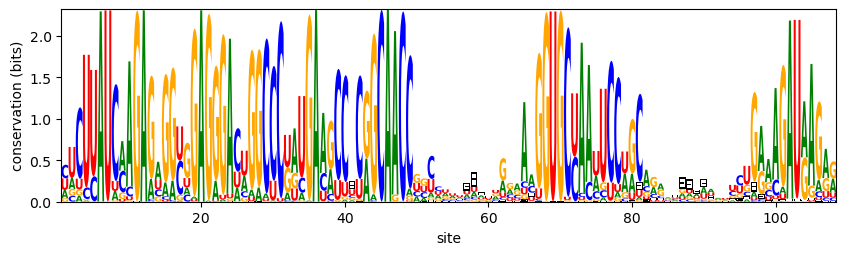

In [7]:
seqlogo_entropic(reshape(mean(data_hits; dims=3), 5, 108)).fig

# Train RBM

In [8]:
function callback(; rbm, optim, state, ps, iter, vm, vd, ∂)
    if iszero(iter % 500)
        Δt = @elapsed (lpl = mean(log_pseudolikelihood(rbm, data_hits)))
        @info iter lpl Δt
    end
end

callback (generic function with 1 method)

In [9]:
rbm = RBM(Potts((5, 108)), xReLU((100,)), zeros(5, 108, 100))
initialize!(rbm, data_hits);
rbm = standardize(rbm);

In [10]:
training_time = @elapsed begin
    state, ps = pcd!(
        rbm, data_hits;
        optim=Adam(1f-4, (0f0, 999f-3), 1f-6), steps=50, batchsize=256, iters=50000, 
        vm = bitrand(size(rbm.visible)..., 256), l2l1_weights=0.1,
        ϵv=1f-1, ϵh=0f0, damping=1f-1, # parameters controlling the hidden unit statistics normalization
        callback
    )
end

[2024-01-09 11:22:04] Info: 500 lpl = -0.5814152666442901, Δt = 4.947769146


[2024-01-09 11:27:59] Info: 1000 lpl = -0.5439885444079963, Δt = 0.661848266


[2024-01-09 11:33:18] Info: 1500 lpl = -0.506943773425716, Δt = 0.712459868


[2024-01-09 11:38:41] Info: 2000 lpl = -0.5001562876886343, Δt = 0.679702213


[2024-01-09 11:43:59] Info: 2500 lpl = -0.4970121196330699, Δt = 1.186288102


[2024-01-09 11:49:15] Info: 3000 lpl = -0.4695374047326582, Δt = 1.206408439


# Check convergence

In [ ]:
sampled_v = sample_from_inputs(rbm.visible, zeros(size(rbm.visible)..., 2000));
sampled_f = zeros(5000)
@showprogress for t in 1:length(sampled_f)
    sampled_v .= sample_v_from_v(rbm, sampled_v; steps=50)
    sampled_f[t] = mean(free_energy(rbm, sampled_v))
end

In [ ]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=300, height=300)
Makie.lines!(ax, sampled_f)
Makie.resize_to_layout!(fig)
fig

In [ ]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=300, height=300)
Makie.scatter!(ax,
    vec(mean(data_hits; dims=3)),
    vec(mean(sampled_v; dims=3)),
    markersize=5
)
Makie.resize_to_layout!(fig)
fig

In [ ]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=300, height=300)
Makie.scatter!(ax,
    vec(cov(reshape(data_hits, length(rbm.visible), :); dims=2)),
    vec(cov(reshape(sampled_v, length(rbm.visible), :); dims=2)),
    markersize=5
)
Makie.resize_to_layout!(fig)
fig

In [ ]:
extrema(rbm.w)

In [ ]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=300, height=300, yscale=log10)
Makie.stephist!(ax, vec(rbm.w), bins=-1:0.001:1, fillto=1e-5, normalization=:pdf)
Makie.ylims!(ax, 1e-3, 1e3)
Makie.resize_to_layout!(fig)
fig

In [ ]:
seqlogo_fields(rbm.w[:,:,1]).fig

In [ ]:
seqlogo_fields(rbm.w[:,:,2]).fig

In [99]:
[norm(rbm.w[:,:,μ]) for μ = 1:length(rbm.hidden)] |> extrema

(1.6246377f0, 2.2942307f0)